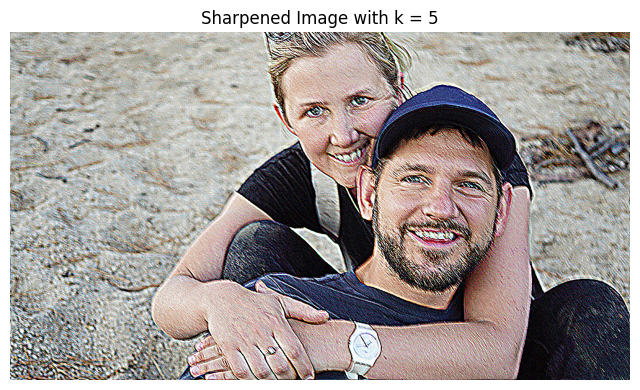

In [77]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_color = cv2.imread('img2.png', cv2.IMREAD_COLOR)


img_color = img_color.astype(np.float32)

kernel = np.array([[-1, -1, -1],
                   [-1,  8, -1],
                   [-1, -1, -1]], dtype=np.float32)

laplacian = cv2.filter2D(img_color, ddepth=-1, kernel=kernel)

sharpened = img_color + 4 * laplacian

sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)

sharpened_rgb = cv2.cvtColor(sharpened, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(sharpened_rgb)
plt.axis('off')
plt.title("Sharpened Image with k = 5")
plt.show()


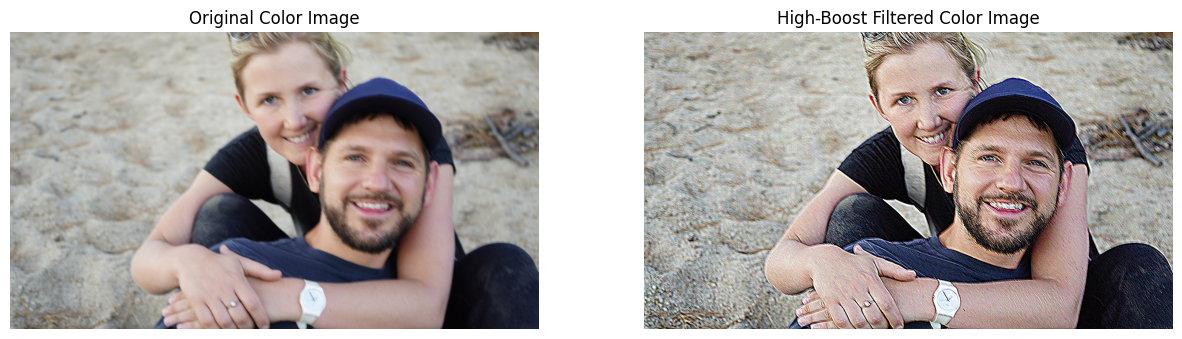

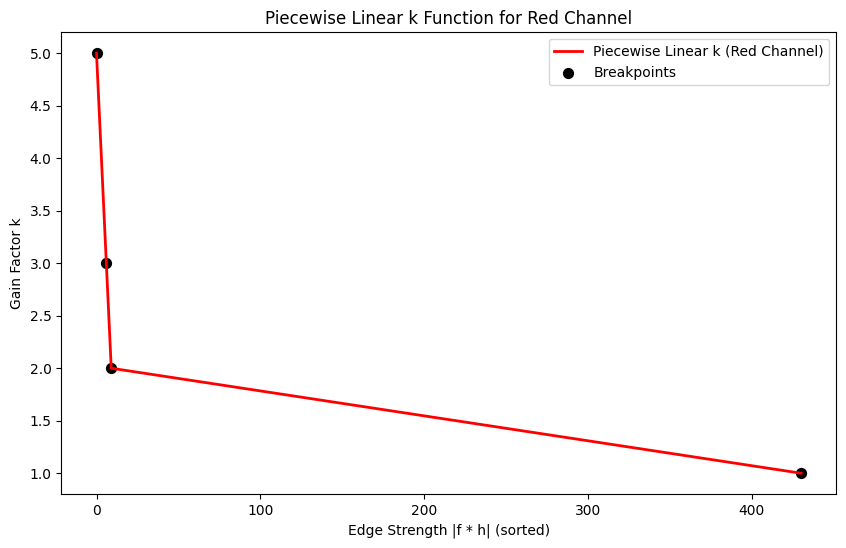

In [80]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import convolve


h = np.array([[-1, -1, -1],
              [-1,  8, -1],
              [-1, -1, -1]], dtype=np.float32)


def compute_k_function(edge_strength_channel):
    flattened = edge_strength_channel.flatten()
    sorted_edge = np.sort(flattened)
    N = len(sorted_edge)
    x0 = sorted_edge[0]
    x1 = sorted_edge[int(0.50 * N)]
    x2 = sorted_edge[int(0.66 * N)]
    x3 = sorted_edge[-1]

    k0, k1, k2, k3 = 5.0, 3.0, 2.0, 1.0

    slope1 = (k1 - k0) / (x1 - x0) if (x1 - x0) != 0 else 0
    intercept1 = k0 - slope1 * x0

    slope2 = (k2 - k1) / (x2 - x1) if (x2 - x1) != 0 else 0
    intercept2 = k1 - slope2 * x1

    slope3 = (k3 - k2) / (x3 - x2) if (x3 - x2) != 0 else 0
    intercept3 = k2 - slope3 * x2

    def k_func_scalar(x):
        if x <= x0:
            return k0
        elif x <= x1:
            return slope1 * x + intercept1
        elif x <= x2:
            return slope2 * x + intercept2
        elif x <= x3:
            return slope3 * x + intercept3
        else:
            return k3

    return np.vectorize(k_func_scalar), (x0, x1, x2, x3)

img_color = cv2.imread('img2.png', cv2.IMREAD_COLOR)
if img_color is None:
    raise ValueError("Image not found. Check the file path.")


channels = cv2.split(img_color)
sharpened_channels = []
k_maps = []

for idx, ch in enumerate(channels):
    f_ch = ch.astype(np.float32)
    L_ch = convolve(f_ch, h)
    edge_strength_ch = np.abs(L_ch)

    k_func, breakpoints = compute_k_function(edge_strength_ch)
    k_map_ch = k_func(edge_strength_ch)
    k_maps.append(k_map_ch)

    g_ch = f_ch + k_map_ch * L_ch

    g_ch_clipped = np.clip(g_ch, 0, 255).astype(np.uint8)
    sharpened_channels.append(g_ch_clipped)

sharpened_color = cv2.merge(sharpened_channels)

img_color_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
sharpened_color_rgb = cv2.cvtColor(sharpened_color, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_color_rgb)
plt.title("Original Color Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sharpened_color_rgb)
plt.title("High-Boost Filtered Color Image")
plt.axis('off')
plt.show()


f_red = channels[2].astype(np.float32)
L_red = convolve(f_red, h)
edge_strength_red = np.abs(L_red)
flattened_red = edge_strength_red.flatten()
sorted_edge_red = np.sort(flattened_red)
k_func_red, breakpoints_red = compute_k_function(edge_strength_red)
sorted_k_red = k_func_red(sorted_edge_red)

plt.figure(figsize=(10, 6))
plt.plot(sorted_edge_red, sorted_k_red, label="Piecewise Linear k (Red Channel)", color='red', linewidth=2)

x0_red, x1_red, x2_red, x3_red = breakpoints_red
plt.scatter([x0_red, x1_red, x2_red, x3_red], [5, 3, 2, 1], color='black', s=50, label="Breakpoints")
plt.xlabel("Edge Strength |f * h| (sorted)")
plt.ylabel("Gain Factor k")
plt.title("Piecewise Linear k Function for Red Channel")
plt.legend()
plt.show()


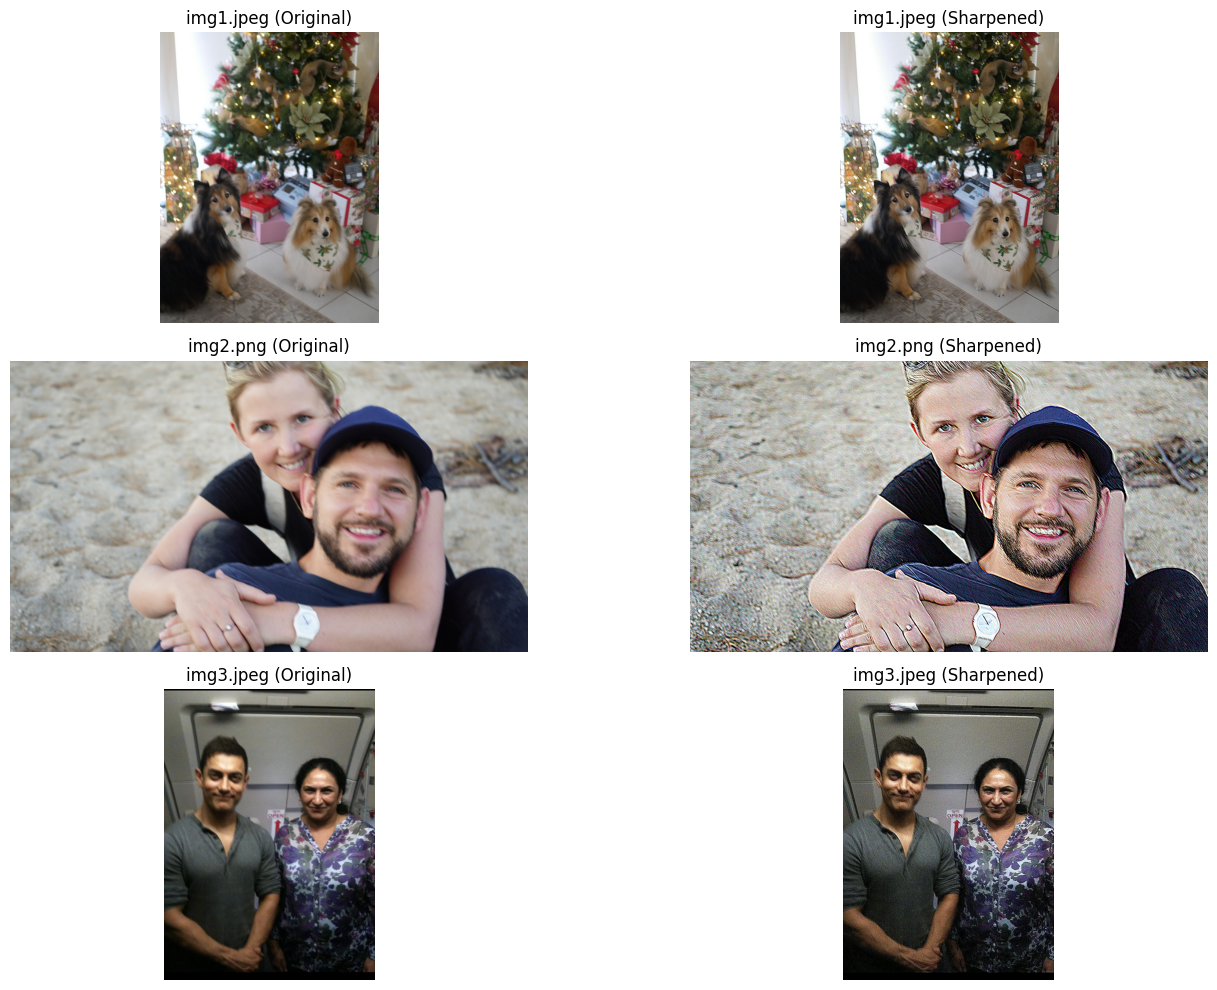

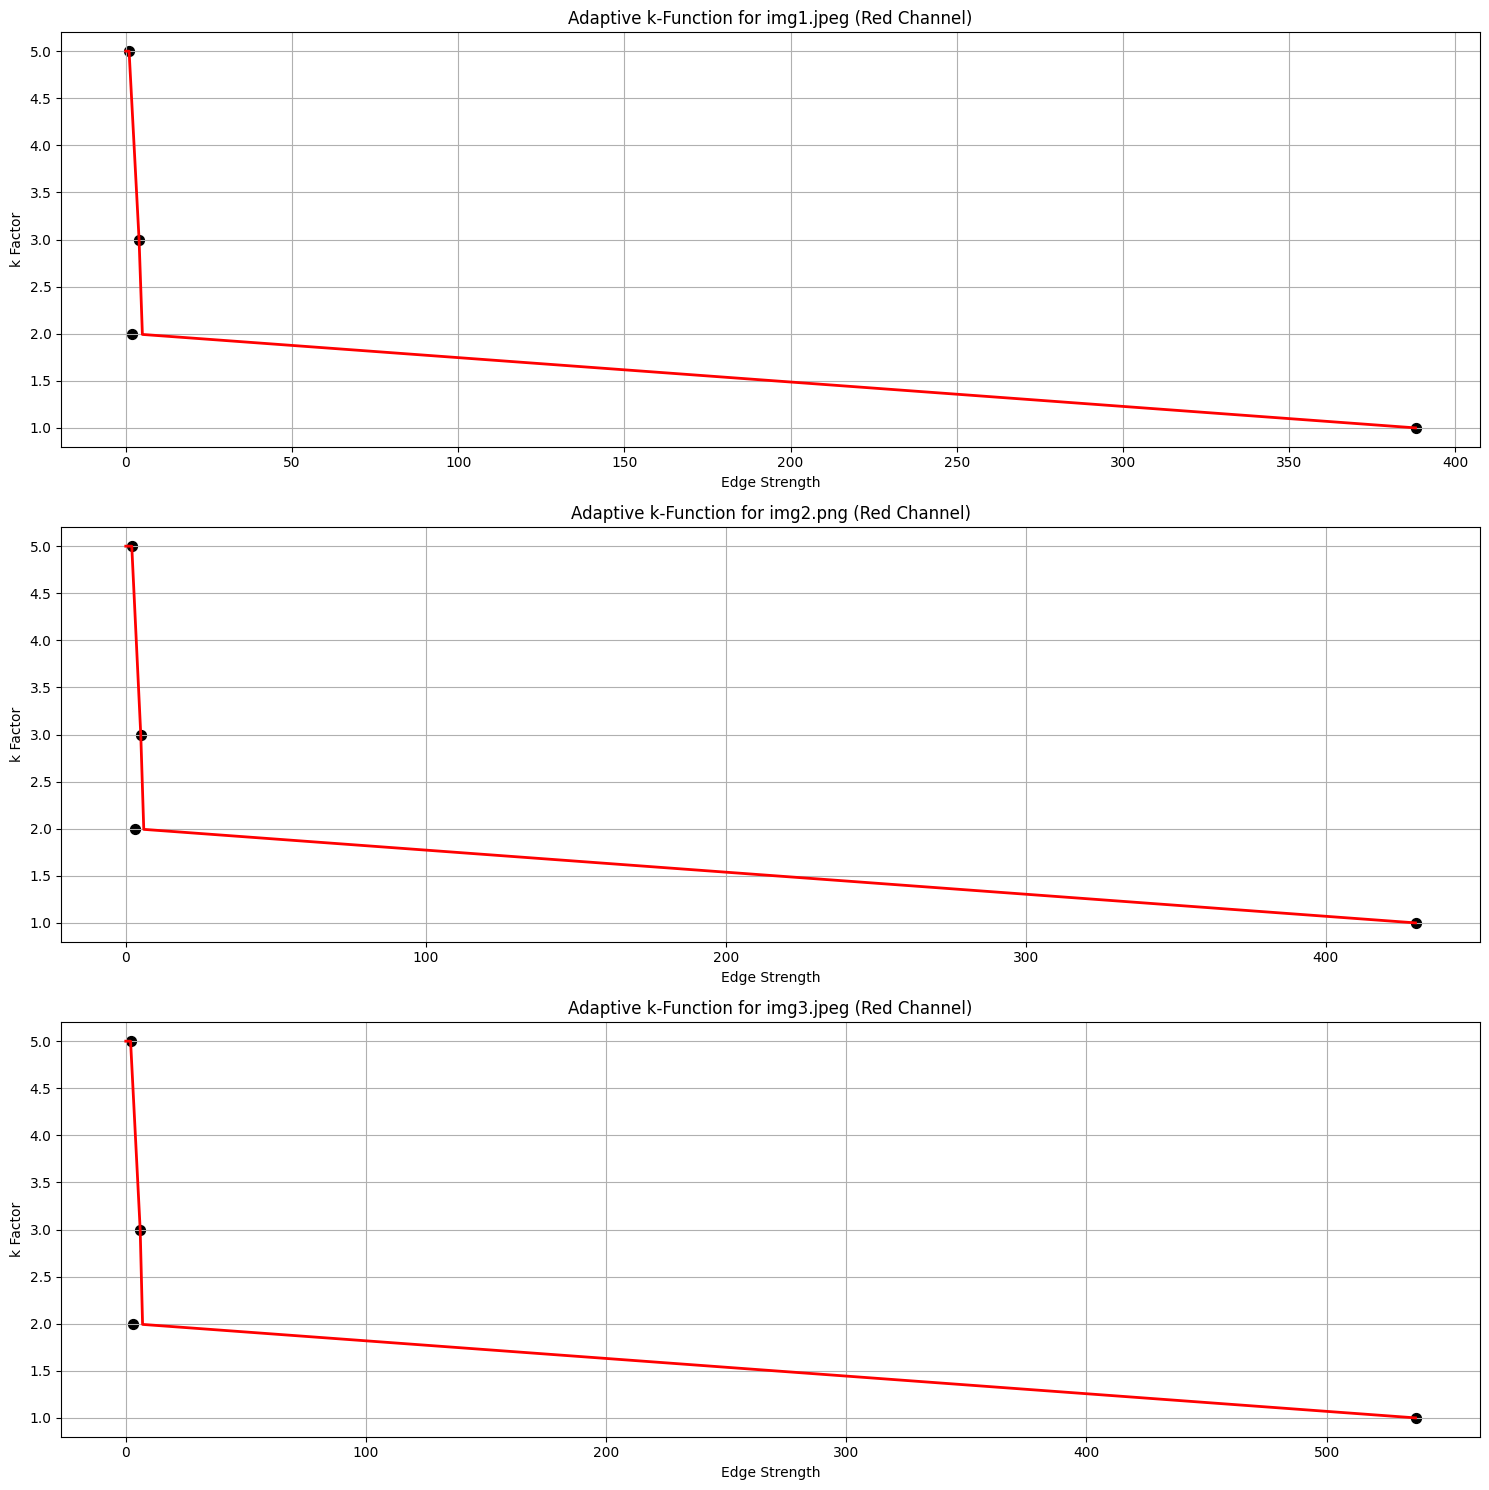

In [83]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

h = np.array([[-1, -1, -1],
              [-1,  8, -1],
              [-1, -1, -1]], dtype=np.float32)

def compute_k_function(edge_strength_channel):
    flattened = edge_strength_channel.flatten()
    sorted_edge = np.sort(flattened)
    N = len(sorted_edge)
    x0 = sorted_edge[int(0.20*N)]
    x1 = sorted_edge[int(0.45 * N)]
    x2 = sorted_edge[int(0.30 * N)]
    x3 = sorted_edge[-1]

    k0, k1, k2, k3 = 5.0, 3.0, 2.0, 1.0

    slope1 = (k1 - k0) / (x1 - x0) if (x1 - x0) != 0 else 0
    intercept1 = k0 - slope1 * x0

    slope2 = (k2 - k1) / (x2 - x1) if (x2 - x1) != 0 else 0
    intercept2 = k1 - slope2 * x1

    slope3 = (k3 - k2) / (x3 - x2) if (x3 - x2) != 0 else 0
    intercept3 = k2 - slope3 * x2

    def k_func_scalar(x):
        if x <= x0:
            return k0
        elif x <= x1:
            return slope1 * x + intercept1
        elif x <= x2:
            return slope2 * x + intercept2
        elif x <= x3:
            return slope3 * x + intercept3
        else:
            return k3

    return np.vectorize(k_func_scalar), (x0, x1, x2, x3)

image_files = ['img1.jpeg', 'img2.png', 'img3.jpeg']

original_images = []
sharpened_images = []
k_function_data = []

for img_file in image_files:
    img_color = cv2.imread(img_file, cv2.IMREAD_COLOR)

    channels = cv2.split(img_color)
    sharpened_channels = []
    k_maps = []

    for ch in channels:
        f_ch = ch.astype(np.float32)
        L_ch = convolve(f_ch, h)
        edge_strength = np.abs(L_ch)
        k_func, _ = compute_k_function(edge_strength)
        k_map = k_func(edge_strength)
        sharpened = f_ch + k_map * L_ch
        sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)
        sharpened_channels.append(sharpened)

    sharpened_color = cv2.merge(sharpened_channels)

    original_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
    sharpened_rgb = cv2.cvtColor(sharpened_color, cv2.COLOR_BGR2RGB)
    original_images.append(original_rgb)
    sharpened_images.append(sharpened_rgb)

    red_channel = channels[2].astype(np.float32)
    L_red = convolve(red_channel, h)
    edge_strength_red = np.abs(L_red).flatten()
    sorted_edge_red = np.sort(edge_strength_red)
    k_func_red, breakpoints = compute_k_function(edge_strength_red)
    sorted_k_red = k_func_red(sorted_edge_red)
    k_function_data.append((sorted_edge_red, sorted_k_red, breakpoints))

plt.figure(figsize=(15, 10))
for i in range(len(image_files)):
    plt.subplot(3, 2, 2*i+1)
    plt.imshow(original_images[i])
    plt.title(f"{image_files[i]} (Original)")
    plt.axis('off')

    plt.subplot(3, 2, 2*i+2)
    plt.imshow(sharpened_images[i])
    plt.title(f"{image_files[i]} (Sharpened)")
    plt.axis('off')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 15))
for i in range(len(image_files)):
    sorted_edge, sorted_k, (x0, x1, x2, x3) = k_function_data[i]

    plt.subplot(3, 1, i+1)
    plt.plot(sorted_edge, sorted_k, color='red', linewidth=2)
    plt.scatter([x0, x1, x2, x3], [5, 3, 2, 1], color='black', s=50)
    plt.xlabel("Edge Strength")
    plt.ylabel("k Factor")
    plt.title(f"Adaptive k-Function for {image_files[i]} (Red Channel)")
    plt.grid(True)

plt.tight_layout()
plt.show()

